# Homework 2, Group A2

## FINM 37500 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Group A2

# 1. Stripping Caps

The file `data/cap_curves_2024-02-16.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.
* the details of the data prep can be found in `build_data/Process Cap Quotes`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_excel("../data/cap_curves_2024-02-16.xlsx")

## Context

Recall that 
* a cap is made of caplets with $.5\le \tau \le T$
* the flat volatility at $T$ is input for every caplet corresponding to the cap of $T$.
* use Black's formula for this calculation.
* in Black's formula, use $T-0.25$ as the rate for the caplet is determined one period before it is paid.

As for the cap parameters,
* the cap's strike is the swap rate with the same tenor. So the $T=2$ cap is struck at the swap rate of $\tau=2$.
* the notional of the cap is $100.
* the payoff of each caplet is

$$\frac{100}{n}\max(r-K,0)$$

where $n$ is the frequency; here $n=4$.

Thus, the corresponding value in Black's fomula for a caplet is
$$P^{\text{cap}}_{T} = \frac{100}{n} \sum_{\tau=.5}^T B_{\text{call}}(\overline{\sigma}_T, \tau-.25, K=s_T, f_{\tau}, Z_{\tau})$$
Note here that for every caplet in cap $T$, we plug in the same 
* flat vol with tenor $T$.
* strike which is the swap rate of maturity $T$.

The notation above is using subscripts for tenor / maturity rather than time period. That is, $Z_{\tau}$ denotes $Z(t, t+\tau)$ which is today's discount factor for maturity $\tau$. Similarly for the swap rate of tenor $T$, denoted above $s_T$ and forward rate $f(t,t+\tau-.25, t+\tau)$ denoted simply $f_{\tau}$.

### Black's Formula
Recall Black's formula:

$$\begin{align}
B_{\text{call}}(\sigma, T, K, f, Z) = &\; Z\left[f\mathcal{N}\left(d_1\right) - K\mathcal{N}(d_2)\right] \\
d_1 =& \frac{\ln\left(\frac{f}{K}\right) + \frac{\sigma^2}{2}T}{\sigma\sqrt{T}} \\
d_2 =& d_1 -\sigma\sqrt{T}
\end{align}
$$

In [45]:
from scipy.stats import norm
from scipy.optimize import minimize

def Blacks_formula(sigma, maturity, strike, F, discount, price='Call'):
    '''
    Inputs: Volatility, Maturity, strike, Forward, discount, and type of option 'Call' or 'Put'
    Returns option's price.
    '''
    vol=sigma
    T=maturity
    K=strike
    Z=discount
    d1=(np.log(F/K)+(((vol**2)*T)/2))/(vol*(T**(1/2)))
    d2=d1-(vol*(T**(1/2)))
    if price=='Call':
        return Z*((F*norm.cdf(d1))-(K*norm.cdf(d2)))
    if price=='Put':
        return Z*((K*norm.cdf(-d2))-(F*norm.cdf(-d1)))

def price_cap_floor(sigma, maturity, strike, F, discount, instrument='Cap', n=4):
    if np.isnan(sigma):
        return np.nan
    if instrument=='Cap':
        price='Call'
    if instrument == 'Floor':
        price='Put'
    tp=0
    for i in range(2,int(n*maturity)+1):
        tp+=Blacks_formula(sigma, (i/n)-(1/n), strike, F[i-1], discount[i-1], price)
    return (100/n)*tp

def forward_vols_from_instrument_prices(cap_prices, maturities, strikes, Fs, discounts, price='Call'):
    cap_prices=np.array(cap_prices)
    maturities=np.array(maturities)
    strikes=np.array(strikes)
    Fs=np.array(Fs)
    discounts=np.array(discounts)

    n=1/(maturities[1]-maturities[0])
    res=np.zeros((len(cap_prices)))
    
    for i, cap_price in enumerate(cap_prices):
        if np.isnan(cap_price):
            res[i]=np.nan
        else:
            tp=0
            for ii in range(i):
                if not np.isnan(res[ii]):
                    tp+=Blacks_formula(res[ii],maturities[ii-1],strikes[i],Fs[ii],discounts[ii],price)
            ttp=cap_price-(tp*100/n)
            def helper(sigma):
                return ((Blacks_formula(sigma, maturities[i-1], strikes[i], Fs[i], discounts[i], price)*100/n) - (ttp))**2
            res[i]=minimize(helper,[0.05], tol=1e-8).x[0]
    return res

def continuous_from_discount(discount, maturity):
    '''Returns the continuous rate from the discount factor and the maturity'''
    return -np.log(discount)/maturity

def compounded_from_discount(discount, maturity, freq=2):
    '''Returns the compounded rate from the discount factor and the maturity'''
    return ((1/discount)**(1/(maturity*freq))-1)*freq

def discount_from_continuous(continuous, maturity):
    '''Returns the discount factor from the continuous rate and the maturity'''
    return np.exp(-continuous*maturity)

def discount_from_compounded(compounded, maturity, freq=2):
    '''Returns the discount factor from the compounded rate and the maturity'''
    return (1+compounded/freq)**(-maturity*freq)

def display_tree(periods, levels, attribute):
    temp=pd.DataFrame()
    for i in range(1,len(levels)+1):
        temp_level=[]
        for j in range(len(levels[-i])):
            temp_level.append(getattr(levels[-i][j],attribute))
        temp[round(periods[-i],2)]=temp_level+['']*(len(levels[-1])-len(temp_level))
    temp.sort_index(axis=1, inplace=True)
    temp.columns=temp.columns.astype(str)
    return temp.style.format("{:.2}")
        
def display_tree_no_attribute(periods, levels):
    temp=pd.DataFrame()
    for i in range(1,len(levels)+1):
        temp_level=[]
        for j in range(len(levels[-i])):
            temp_level.append(levels[-i][j])
        temp[round(periods[-i],2)]=temp_level+['']*(len(levels[-1])-len(temp_level))
    temp.sort_index(axis=1, inplace=True)
    temp.columns=temp.columns.astype(str)
    return temp
    
class tree_convention:
    UP=1
    DOWN=-1
    ORIGIN=0
    TERMINAL=2
    DUMMY=3
    
class interest_node():
    def __init__(self, period, rate, state=tree_convention.DUMMY):
        self.period = period
        self.rate = rate
        self.state = state

    def __repr__(self):
        return 'rate: {:.2%}\nperiod: {}\nstate: {}'.format(self.rate,self.period,self.state)
    
class Interest_Tree():
    def __init__(self, periods, rates=None):
        self.periods = periods
        self.rates = rates
        self.levels = []

    def tree_from_discounts_theta_sigma(self,discounts,theta,sigma,freq=4):
        self.levels.append([interest_node(0,continuous_from_discount(discounts[0],1/freq),tree_convention.ORIGIN)])
        for i in range(1,len(self.periods)):
            tlevel=[]
            ttheta=theta[i-1]
            tsigma=sigma[i-1]
            for j in range(len(self.levels[i-1])):
                trate=self.levels[i-1][j].rate
                tlrate=np.log(trate*100)
                tlrateup=tlrate+(ttheta*(1/freq))+(tsigma*np.sqrt(1/freq))
                trateup=np.exp(tlrateup)/100                   
                node=interest_node(self.periods[i],trateup)
                tlevel.append(node)
                if j == i-1:
                    tlratedown=tlrate+(ttheta*(1/freq))-(tsigma*np.sqrt(1/freq))
                    tratedown=np.exp(tlratedown)/100
                    node=interest_node(self.periods[i],tratedown)
                    tlevel.append(node)
            self.levels.append(tlevel)

    def __repr__(self):
        tree_str = 'Rates_Tree [%]:\n'
        for level_index, level in enumerate(self.levels):
            level_str = '  ' * level_index
            for node in level:
                node_str = '{:.2f}'.format(
                    node.rate*100)
                level_str += node_str + ' '
            tree_str += 'period: {} ||'.format(node.period) + level_str.strip() + '\n'
        return tree_str.strip()
                

class bond_node():
    def __init__(self, period, price, state, maturity,expected_price=None):
        self.period = period
        self.price = price
        self.state = state
        self.maturity = maturity
        self.expected_price=expected_price
        self.rn_probUP=1/2
        self.rn_probDOWN=1/2

    def __repr__(self):
        return 'period: {}\nstate: {}\nprice: {:.2f}\nmaturity: {}'.format(self.period, self.state, self.price, self.maturity)

class Binary_Bond_Tree():
    def __init__(self, periods=None, price=None, face_value=100, interest_tree=None, maturity=None):
        self.periods = np.array(periods)
        if len(price)<=1:
            self.price=price
        else:
            self.price=np.array(price)
        self.face_value = face_value
        self.levels = []
        self.interest_tree = interest_tree
        self.maturity = maturity
        self.thetas=[]
        self.sigmas=np.zeros(())

    def tree_from_sigmas(self,sigmas,periods=None, prices=None):
        sigmas=np.array(sigmas)
        if periods is not None:
            self.periods=periods
        freq=1/(self.periods[1]-self.periods[0])
        if prices is not None:
            self.price=prices
        self.sigmas=sigmas
        for i in range(len(self.periods)-2):
            def helper(theta):
                ttree=Interest_Tree(self.periods[:i+2])
                ttree.tree_from_discounts_theta_sigma(self.price[:i+2]/100,np.append(self.thetas[:i],theta),sigmas[:i+2],freq)
                tjprices=[]
                for j in range(len(ttree.levels[-1])):
                    tjprices.append(self.face_value*np.exp(-ttree.levels[-1][j].rate*(1/freq)))
                for j in range(2,len(ttree.levels)+1):
                    tkprices=[]
                    for k in range(len(ttree.levels[-j])):
                        average=(tjprices[k]+tjprices[k+1])/2
                        tkprice=average*np.exp(-ttree.levels[-j][k].rate*(1/freq))
                        tkprices.append(tkprice)
                    tjprices=tkprices
                if len(tjprices)!=1:
                    print('Error', len(tjprices))
                return (tjprices[0]-self.price[i+1])**2
            theta=minimize(helper,[0.5], tol=1e-8).x[0]
            self.thetas.append(theta)
        ttree=Interest_Tree(self.periods[:-1])
        ttree.tree_from_discounts_theta_sigma(self.price/100,self.thetas,sigmas,freq)
        self.interest_tree=ttree

    def __repr__(self):
        tree_str = 'Binary_Bond_tree:\n'
        tree_str += '                               Maturity: {}\n'.format(self.maturity)
        for level_index, level in enumerate(self.levels[:-1]):
            level_str = '  ' * level_index
            for node in level:
                node_str = '[state: {}, price: {:.2f}]'.format(
                    node.state, node.price)
                level_str += node_str + '  '
            tree_str += 'period: {} '.format(node.period) + level_str.strip() + '\n'
        return tree_str.strip()

## 1.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

In [46]:
df=data.copy()
df['Cap_Price']=df.apply(lambda x: price_cap_floor(x['flat vols'], x['tenor'], x['swap rates'], np.array(df['forwards']), np.array(df['discounts'])), axis=1)
df.style.format('{:.2f}')

,tenor,swap rates,discounts,forwards,flat vols,fwd vols,Cap_Price
0,0.25,0.05,0.99,nan,nan,nan,nan
1,0.50,0.05,0.97,0.05,0.16,0.16,0.03
2,0.75,0.05,0.96,0.05,0.19,0.21,0.10
3,1.00,0.05,0.95,0.05,0.21,0.25,0.19
4,1.25,0.05,0.94,0.04,0.26,0.36,0.33
5,1.50,0.05,0.93,0.04,0.29,0.37,0.50
6,1.75,0.05,0.92,0.04,0.31,0.38,0.68
7,2.00,0.05,0.91,0.04,0.33,0.38,0.87
8,2.25,0.04,0.91,0.04,0.33,0.36,1.06
9,2.50,0.04,0.90,0.04,0.34,0.35,1.25


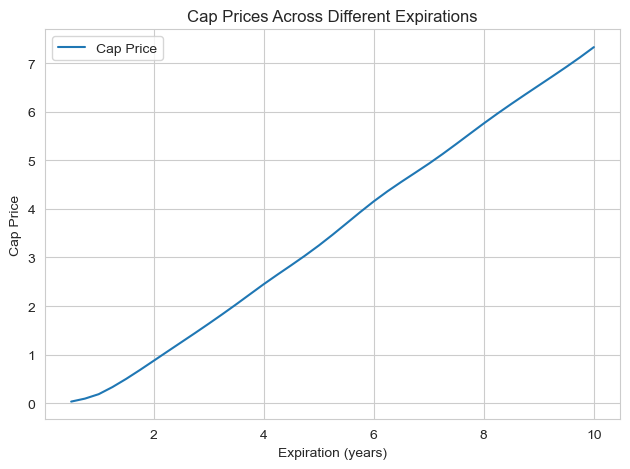

In [47]:
sns.set_style("whitegrid")

sns.lineplot(x=df['tenor'], y=df['Cap_Price'], label='Cap Price')

plt.xlabel('Expiration (years)')
plt.ylabel('Cap Price')
plt.title('Cap Prices Across Different Expirations')

# plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


## 1.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

In [48]:
df['Forward_Vol']=forward_vols_from_instrument_prices(df['Cap_Price'], df['tenor'], df['swap rates'], np.array(df['forwards']), np.array(df['discounts']))
df

,tenor,swap rates,discounts,forwards,flat vols,fwd vols,Cap_Price,Forward_Vol
0,0.25,0.053220,0.986870,NaN,NaN,NaN,NaN,NaN
1,0.50,0.052569,0.974225,0.051917,0.164498,0.164498,0.034285,0.164498
2,0.75,0.051547,0.962315,0.049503,0.189530,0.208622,0.095557,0.208622
3,1.00,0.050334,0.951210,0.046700,0.214562,0.251768,0.186823,0.251768
4,1.25,0.048626,0.941373,0.041799,0.257098,0.355909,0.333136,0.355909
5,1.50,0.047222,0.932004,0.040209,0.288577,0.372774,0.501898,0.372774
6,1.75,0.046049,0.923001,0.039018,0.310668,0.379028,0.684697,0.379028
7,2.00,0.045095,0.914218,0.038426,0.325038,0.375009,0.874438,0.375009
8,2.25,0.044138,0.905954,0.036487,0.333356,0.362712,1.064923,0.362712
9,2.50,0.043422,0.897654,0.036988,0.337288,0.349289,1.254443,0.349289


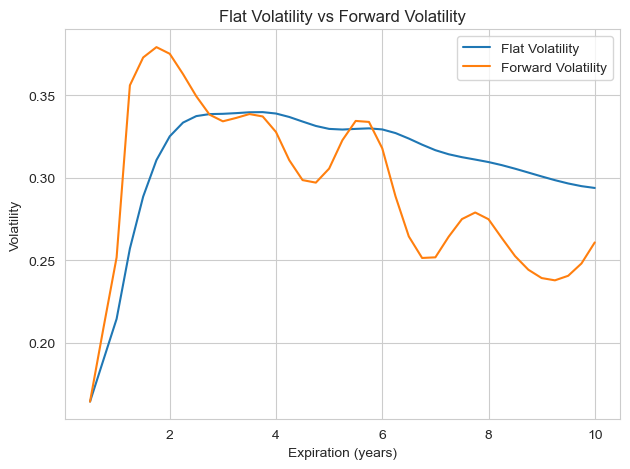

In [49]:
sns.set_style("whitegrid")

sns.lineplot(x=df['tenor'], y=df['flat vols'], label='Flat Volatility')
sns.lineplot(x=df['tenor'], y=df['Forward_Vol'], label='Forward Volatility')

plt.xlabel('Expiration (years)')
plt.ylabel('Volatility')
plt.title('Flat Volatility vs Forward Volatility')

plt.legend()
plt.tight_layout()

plt.show()

## 1.3 Calibrate a BDT model 

Use data from the file `data/cap_curves_2024-02-16.xlsx` to calibrate the BDT model.
* Use the forward volatilities calculated in 1.2 to calibrate $\sigma$ at each step. 
* You do not have a forward volatility at $\tau=.25$ given there is no caplet there. For purposes of the BDT model, assume $\sigma_{.25}$ is equal to the forward volatility at the first estimated period, $t=0.50$. That is, use the first estimated forward vol (corresponding to $\tau=.50$ for both $t=.25$ and $t=.50$ in the BDT tree.    

Given these volatility parameters, calibrate the series of $\theta$ to fit the zero-coupon bond prices given by `discounts` (multiplied by 100).

**Display**
* the series of $\theta$ parameters.
* the tree of rates from $0\le t \le 10$.

In [50]:
Tree=Binary_Bond_Tree(periods=np.arange(0,10.25,1/4),price=np.array(df['discounts'])*100)
Tree.tree_from_sigmas(np.array(df['Forward_Vol'].bfill()))

In [51]:
thetas=pd.DataFrame({'Period':np.arange(1/4,10,1/4),'Theta [%]':np.array(Tree.thetas)*100})
thetas.style.format('{:.2f}')

,Period,Theta [%]
0,0.25,-11.18
1,0.50,-20.23
2,0.75,-31.59
3,1.00,-58.60
4,1.25,-47.43
5,1.50,-43.47
6,1.75,-34.78
7,2.00,-44.57
8,2.25,-12.46
9,2.50,-8.38


In [52]:
display_tree(Tree.periods,Tree.interest_tree.levels, 'rate')

,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.0,7.25,7.5,7.75,8.0,8.25,8.5,8.75,9.0,9.25,9.5,9.75,10.0
0,0.053,0.056,0.058,0.059,0.058,0.061,0.066,0.074,0.079,0.092,0.11,0.13,0.14,0.17,0.2,0.24,0.28,0.33,0.4,0.48,0.57,0.67,0.79,0.93,1.1,1.3,1.6,1.9,2.2,2.6,3.0,3.6,4.2,5.0,5.9,6.9,8.1,9.5,1.1e+01,1.3e+01
1,,0.047,0.049,0.05,0.049,0.052,0.056,0.062,0.067,0.078,0.091,0.11,0.12,0.14,0.17,0.2,0.23,0.28,0.34,0.41,0.48,0.57,0.67,0.79,0.94,1.1,1.3,1.6,1.9,2.2,2.6,3.0,3.6,4.2,5.0,5.8,6.9,8.1,9.4,1.1e+01
2,,,0.041,0.043,0.042,0.044,0.048,0.053,0.057,0.066,0.077,0.092,0.1,0.12,0.15,0.17,0.2,0.23,0.29,0.35,0.41,0.48,0.57,0.67,0.8,0.95,1.1,1.3,1.6,1.9,2.2,2.6,3.0,3.6,4.2,5.0,5.8,6.8,8.0,9.4
3,,,,0.035,0.034,0.036,0.039,0.043,0.046,0.054,0.063,0.074,0.084,0.097,0.12,0.14,0.16,0.19,0.23,0.28,0.33,0.39,0.46,0.54,0.65,0.77,0.91,1.1,1.3,1.5,1.8,2.1,2.5,2.9,3.4,4.0,4.7,5.5,6.5,7.6
4,,,,,0.026,0.028,0.03,0.033,0.036,0.042,0.049,0.058,0.065,0.075,0.092,0.11,0.13,0.15,0.18,0.22,0.26,0.3,0.36,0.42,0.5,0.6,0.71,0.84,0.99,1.2,1.4,1.6,1.9,2.3,2.7,3.1,3.7,4.3,5.1,5.9
5,,,,,,0.02,0.021,0.023,0.025,0.029,0.034,0.04,0.046,0.053,0.064,0.077,0.088,0.1,0.13,0.15,0.18,0.21,0.25,0.3,0.35,0.42,0.5,0.59,0.69,0.82,0.97,1.1,1.3,1.6,1.9,2.2,2.6,3.0,3.5,4.1
6,,,,,,,0.015,0.016,0.017,0.02,0.024,0.028,0.031,0.036,0.044,0.053,0.061,0.071,0.087,0.11,0.12,0.15,0.17,0.2,0.24,0.29,0.34,0.41,0.48,0.56,0.67,0.78,0.93,1.1,1.3,1.5,1.8,2.1,2.4,2.9
7,,,,,,,,0.011,0.012,0.014,0.016,0.019,0.021,0.025,0.03,0.036,0.041,0.049,0.06,0.072,0.085,0.1,0.12,0.14,0.17,0.2,0.23,0.28,0.33,0.39,0.46,0.54,0.63,0.75,0.88,1.0,1.2,1.4,1.7,2.0
8,,,,,,,,,0.0082,0.0095,0.011,0.013,0.015,0.017,0.021,0.025,0.028,0.034,0.041,0.05,0.059,0.069,0.081,0.096,0.11,0.14,0.16,0.19,0.23,0.27,0.31,0.37,0.44,0.51,0.6,0.71,0.83,0.98,1.1,1.3
9,,,,,,,,,,0.0066,0.0077,0.0091,0.01,0.012,0.015,0.017,0.02,0.023,0.029,0.035,0.041,0.048,0.056,0.067,0.08,0.095,0.11,0.13,0.16,0.18,0.22,0.26,0.3,0.36,0.42,0.49,0.58,0.68,0.8,0.93


***

# 2. Pricing a Callable Bond with BDT

## Freddie Mac

The U.S. has many forms of *agency* debt in addition to *Treasury* debt. The largest of these *agency* issuers are the housing entities commonly referred to as Freddie Mac and Fannie Mae. While technically distinct from the U.S. Treasury, they are widely seen as having the full credit and backing of the Treasury--particularly after the bailouts of 2008.

Thus, we will examine this agency debt as (credit) risk-free, just like Treasury debt.

Consider the Freddie Mac bond with Bloomberg ID `COZD1131782`, CUSIP `3134H1TN3`.
* Issued 2024-02-16
* Matures 2034-02-21
* Semiannual coupons
* Coupon rate 6.00%

Note that these bonds are not a niche market. Just this particular bond was issued with \$15 billion face value.

## 2.1 Price the Freddie Mac Bond


Assume today is `2024-02-16`.
* The market price on this day is `$99.953`.
* Approximate the TTM (time-to-maturity) to be exactly 10 years.

Price this bond using the model calibrated from  data.
* Price it with the BDT model calibrated in the previous problem.
* Note that the coupons are paid semiannually whereas the tree steps are quarterly.

Report the tree of bond prices, emphasizing the current modeled price.

How does our modeled price compare to the market price?

In [11]:
coupPay=True
coupon=0.06
freq_b=2
face=100
rates=Tree.interest_tree
freq=1/(Tree.periods[1]-Tree.periods[0])
tprices=[]
historical=[]
for j in range(len(rates.levels[-1])):
    tprices.append((face*(1+(coupPay*coupon/freq_b)))*np.exp(-rates.levels[-1][j].rate*(1/freq)))
coupPay= not coupPay
historical.append(tprices)
for j in range(2,len(rates.levels)+1):
    tkprices=[]
    for k in range(len(rates.levels[-j])):
        average=(tprices[k]+tprices[k+1])/2
        average+=coupPay*face*coupon/freq_b
        fact=np.exp(-rates.levels[-j][k].rate*(1/freq))
        tkprice=average*fact
        tkprices.append(tkprice)
    coupPay= not coupPay
    tprices=tkprices
    historical.append(tprices)

historical=historical[::-1]
print('The price of the bond through the tree is {:.2f}'.format(tprices[0]))
print('It seems higher than the 99.953 price reported through the market')

The price of the bond through the tree is 116.65
It seems higher than the 99.953 price reported through the market


In [12]:
display_tree_no_attribute(Tree.periods, historical)

,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,...,7.75,8.0,8.25,8.5,8.75,9.0,9.25,9.5,9.75,10.0
0,116.645618,113.27681,106.648674,102.675816,95.395173,90.705928,82.795254,77.677804,69.49057,64.19901,...,0.746452,1.41688,0.366994,0.925212,0.151788,0.554514,0.059329,0.330621,0.323623,3.961202
1,,123.118384,117.088604,113.716081,107.012711,102.865593,95.424085,90.684156,82.748648,77.567757,...,1.101836,1.77341,0.571573,1.184577,0.268112,0.758216,0.144815,0.566035,0.772685,6.493161
2,,,126.080456,123.34012,117.287687,113.803573,107.004865,102.870287,95.47149,90.739252,...,1.868739,2.423418,1.009947,1.615042,0.538078,1.098731,0.38867,1.044422,1.703741,9.874845
3,,,,131.448216,126.029148,123.227588,117.131691,113.711093,107.010192,102.950221,...,3.806266,4.031887,2.222857,2.703352,1.36885,1.98804,1.197619,2.287523,3.820842,15.355909
4,,,,,133.145815,130.970538,125.544316,122.834679,116.868362,113.565568,...,8.219454,7.830631,5.382614,5.534198,3.813095,4.451347,3.672602,5.518236,8.479126,23.455654
5,,,,,,137.076934,132.229941,130.153725,124.861388,122.287128,...,16.49445,15.377606,12.137448,11.85428,9.659697,10.376869,9.784923,12.884167,17.94608,36.532547
6,,,,,,,137.266608,135.706306,130.973532,129.017206,...,28.30344,26.626,22.754857,22.111053,19.559315,20.405013,20.105176,24.355924,30.878338,50.438182
7,,,,,,,,139.827276,135.53512,134.071473,...,42.138162,40.229854,36.042731,35.246192,32.520934,33.512926,33.40928,38.278133,45.060638,63.180164
8,,,,,,,,,138.891993,137.806896,...,56.069114,54.214602,49.984383,49.210053,46.432833,47.505078,47.367962,52.222113,58.230541,73.613407
9,,,,,,,,,,140.545995,...,68.699725,67.055627,62.931688,62.254935,59.454665,60.492525,60.096045,64.476601,69.165033,81.533419


## 2.2 Callable Bond

One important difference between Treasury debt and this bond is that this bond is **callable**
* Note that the holder of the bond is short this call option; (the issuer has the optionality.) 

#### Style
* (approximately) American style
* called only on quarterly dates, not any date
* since our tree is quarterly, this means callable on any date on our tree.

#### Strike
* Strike is 100.
* The strike is based on the **clean** price of the bond, meaning the price which does not account for accrued interest.
    * In pricing the bond in the previous problem, you should have considered the accrued coupons, or dirty prices.
    * But in analyzing the option, you must consider its moneyness and payoff based on the clean price.

### Pricing
Use the BDT model to price this implicit American call option and the resulting callable bond.
* Note that the price of the callable bond is your answer to the previous question minus this American option.
* How close is the modeled price to the market quoted price now that you are accounting for the short embedded option? 

Does the price of the callable bond ever get above \$100?

**Answer**: The price should not get above 100, since then the call would be exercised.

In [13]:
clean=[]
for i in historical:
    clean.append(i.copy())

coupPay=True
for j in range(1,len(rates.levels)):
    for k in range(len(clean[j])):
        clean[j][k]-=(coupPay*face*coupon/freq_b)*np.exp(-rates.levels[j][k].rate*(1/freq))/2
    coupPay= not coupPay

display_tree_no_attribute(Tree.periods, clean)


,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,...,7.75,8.0,8.25,8.5,8.75,9.0,9.25,9.5,9.75,10.0
0,116.645618,111.797597,106.648674,101.197813,95.395173,89.228788,82.795254,76.205138,69.49057,62.733206,...,0.746452,0.80427,0.366994,0.492863,0.151788,0.28638,0.059329,0.190849,0.323623,3.903515
1,,121.636037,117.088604,112.234763,107.012711,101.385008,95.424085,89.207376,82.748648,76.096817,...,1.101836,1.071673,0.571573,0.662445,0.268112,0.410064,0.144815,0.365703,0.772685,6.398600
2,,,126.080456,121.855983,117.287687,112.320059,107.004865,101.390009,95.47149,89.26394,...,1.868739,1.635981,1.009947,1.002272,0.538078,0.664238,0.38867,0.772545,1.703741,9.731036
3,,,,129.961105,126.029148,121.740984,117.131691,112.227121,107.010192,101.470292,...,3.806266,3.142858,2.222857,1.978071,1.36885,1.439374,1.197619,1.912518,3.820842,15.132280
4,,,,,133.145815,129.480962,125.544316,121.347154,116.868362,112.081195,...,8.219454,6.831829,5.382614,4.681594,3.813095,3.76503,3.672602,5.007685,8.479126,23.114067
5,,,,,,135.584245,132.229941,128.662476,124.861388,120.798093,...,16.49445,14.249452,12.137448,10.844517,9.659697,9.509482,9.784923,12.179144,17.94608,36.000519
6,,,,,,,137.266608,134.212339,130.973532,127.524767,...,28.30344,25.393269,22.754857,20.968958,19.559315,19.376439,20.105176,23.46419,30.878338,49.703645
7,,,,,,,,138.331409,135.53512,132.576653,...,42.138162,38.918398,36.042731,34.001532,32.520934,32.354341,33.40928,37.227413,45.060638,62.260065
8,,,,,,,,,138.891993,136.310458,...,56.069114,52.846883,49.984383,47.890602,46.432833,46.249039,47.367962,51.047664,58.230541,72.541367
9,,,,,,,,,,139.048474,...,68.699725,65.64895,62.931688,60.882987,59.454665,59.166797,60.096045,63.211401,69.165033,80.346039


In [14]:
temp=[max(0,i-100) for i in clean[-1]]
callable=[]
callable.append(temp.copy())
for j in range(2,len(rates.levels)+1):
    tkprices=[]
    for k in range(len(clean[-j])):
        average=(temp[k]+temp[k+1])/2
        tkprice=average*np.exp(-rates.levels[-j][k].rate*(1/freq))
        tkprices.append(max(tkprice, max(0,clean[-j][k]-100)))
    temp=tkprices
    callable.append(temp.copy())

callable=callable[::-1]
display_tree_no_attribute(Tree.periods, callable)
    

,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,...,7.75,8.0,8.25,8.5,8.75,9.0,9.25,9.5,9.75,10.0
0,17.579889,13.991546,10.766352,8.048143,5.834774,4.083974,2.759867,1.796876,1.123132,0.670291,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,,21.636037,17.609974,13.796962,10.501073,7.755682,5.534486,3.815241,2.537326,1.620995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,,,26.080456,21.855983,17.440849,13.505893,10.180278,7.410693,5.213137,3.539811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,,,,29.961105,26.029148,21.740984,17.131691,13.194526,9.805716,7.036434,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,,,,,33.145815,29.480962,25.544316,21.347154,16.868362,12.80366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,,,,,,35.584245,32.229941,28.662476,24.861388,20.798093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,,,,,,,37.266608,34.212339,30.973532,27.524767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,,,,,,,,38.331409,35.53512,32.576653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,,,,,,,,,38.891993,36.310458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,,,,,,,,,,39.048474,...,0.000512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [15]:
price=historical[0][0]-callable[0][0]
price

99.06572814459

<Axes: >

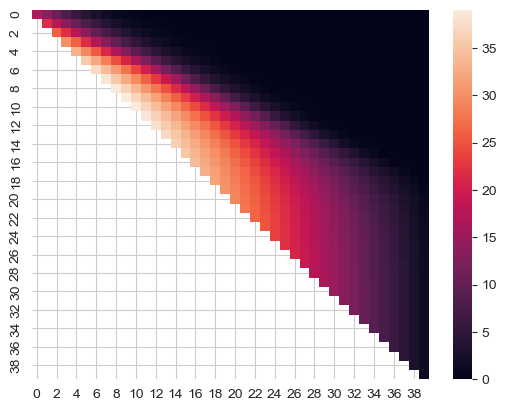

In [16]:
sns.heatmap(pd.DataFrame(callable).T)

## 2.3 Exercising the Option

Show a heatmap of the nodes in which the American bond is exercised.

Is it exercised every time it is in-the-money?

**Answer**: While the model suggests that everytime it is advantageous to exercise, the issuer will exercise, this could be a very simplistic way of viewing this. This is because real life financing can be complicated. For example it is possible that while it is advantageous to exercise, the issuer was unable to secure the funds to 'finance' the buyback. The way companies typically finance is by rolling over the debt, that is by issuing new bonds at market rates to finance the call option exercise. There are circumstances where this may not be economically feasible, and so the exercise may not occur. 

<Axes: >

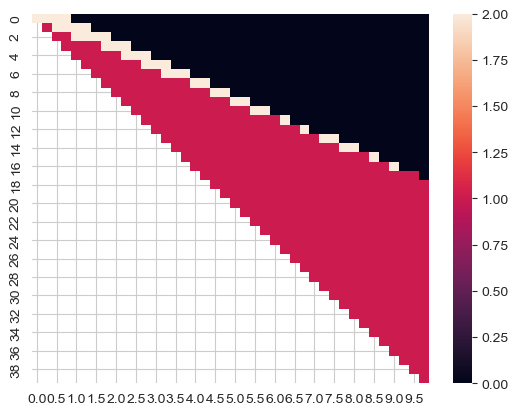

In [17]:
exercising=[]
temp=[]
for i in range(len(clean[-1])):
    if clean[-1][i]-100<0:
        temp.append(0)
    else:
        temp.append(1)
exercising.append(temp)
for i in range(2,len(callable)+1):
    temp=[]
    for j in range(len(callable[-i])):
        if clean[-i][j]-100<0:
            temp.append(0)
        else:
            expected_value=(callable[-i+1][j]+callable[-i+1][j+1])/2
            expected_value*=np.exp(-rates.levels[-i][j].rate*(1/freq))
            if expected_value>clean[-i][j]-100:
                temp.append(2)
            else:
                temp.append(1)

    exercising.append(temp)

exercising=exercising[::-1]
tdf=pd.DataFrame(exercising).T
tdf.columns=Tree.periods[:-1]
sns.heatmap(tdf)

***

# 3. Option Adjusted Spread

*This section is optional. No need to submit it, but we will likely discuss it in class.*

## 3.1 Calculate the OAS

The **option adjusted spread** is the spread one would need to add to the spot curve, (the discounts), to get the modeled price to match the market price of the derivative. That is, how many bps would you need to add or subtract to all the spot rates in order to perfectly price this callable bond? 

* Ignore the effect of the parallel shift in rates on the forward vols. (No need to recalculate section 1.) 

* Use the parallel shifts to recalibrate the $\theta$ parameters in the BDT tree. 

Report the OAS needed to add (or subtract) in a parallel shift in spot to correctly model the callable bond.

#### Note:
This **OAS** is a common way to quote whether a derivative seems to be undervalued (positive OAS) or overvalued (negative OAS.) Of course, the OAS is dependent on our modeling choices, so it could also indicate the model is bad.

## 3.2 Convexity

Continue with parallel shifts of the (present, market quoted) yield curve. 
* Plot the relationship between the value of the callable bond as the spot curve shifts higher and lower.
* Do you see convexity in this relationship?

***

In [18]:
# SAME EXAMPLE FROM W.2 Multiperiod Trees and Caps. I can adjust anything and get the same, but for
# larger examples I see some differences. Please consider that the differences should be marginal.

rawdata = np.array([99.1338,
         97.8925,
         96.1462,
         94.1011,
         91.7136,
         89.2258,
         86.8142,
         84.5016,
         82.1848,
         79.7718,
         77.4339])

test_Tree=Binary_Bond_Tree(periods=np.arange(0,6,1/2),price=np.array(rawdata))
test_Tree.tree_from_sigmas(np.array([0.2142]*11))
test_thetas=pd.DataFrame({'Period':np.arange(1/2,5.5,1/2),'Theta [%]':np.array(test_Tree.thetas)*100})

print('Same results as in the class notebook! This is how I confirmed it worked')
test_thetas.style.format('{:.2f}')

Same results as in the class notebook! This is how I confirmed it worked


,Period,Theta [%]
0,0.50,71.83
1,1.00,69.15
2,1.50,33.48
3,2.00,33.78
4,2.50,11.83
5,3.00,-2.30
6,3.50,-4.38
7,4.00,4.55
8,4.50,12.81
9,5.00,-1.26
